## ML Model Backpain Dataset

### Datasource
    1. https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

### Objective
    1. To classify a person into abnormal or normal using collected physical spine data.

### Target
    1. Difference between Train - Test Accuracy < 5%
    2. Test Accuracy >= 90%
    3. Recall >= 90%

### Pre-Processing

#### Libraries

In [1]:
import sys
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [12, 10]

import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# --------------- End of sklearn libraries ---------------------

import catboost as cb

import shap

#### Global Constants

In [2]:
RND_STATE = 42  # random_state where used is assigned RND_STATE
TESTSIZE = 0.1  # test_size where used is assigned TESTSIZE

scoremet = ['accuracy'] # Specify the scoring metrics to be used in Hyperparameter Tuning
scoremet_cbc = ['Accuracy'] # CatBoost module nomenclature changes. Watchout.

In [3]:
nscores = len(scoremet)
nscores_cbc = len(scoremet_cbc)

if (nscores == 0) or (nscores_cbc == 0):
    scoremet = ['f1'] # Default evaluation metrics for Scikit ML Models
    scoremet_cbc = ['F1'] # # Default evaluation metrics for CatBoost Classifier
if nscores > 1 or nscores_cbc > 1:
    sys.exit("Only ONE Evaluation Metric Allowed")

#### I/O Path & File Name

In [4]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\MLM_V2.2_BackPain_FFS_NOR_STRY_US_SDS_Accuracy_42_I1_" # Version#_DatasetName_FullFeatureSet_NoOutlierRemoval__StratifyY_Upsampling_StandardScaler_Metric_Seed_Iteration

# Specify number of features and targets

n_features = 12
n_target = 1

#### Dataframe Construction

In [5]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

#### Encoding

In [6]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [7]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,Normal
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,Patient
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,Normal
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,Patient
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,Patient


In [8]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [9]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [10]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,0
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,1
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,0
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,1
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,1


#### Imputing

In [11]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [12]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [13]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [14]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [15]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



#### Outlier Treatment

In [16]:
# """
#     1. Cell for removing outliers.
#     2. Based on Z-score.
# """
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [17]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



#### Descriptive Stats

In [18]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [19]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_incidence         |     310 |  60.497 | 17.237 |  26.148 |   46.43 |  58.692 |  72.878 | 129.834 |
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| lumbar_lordosis_angle    |     310 |  51.931 | 18.554 |      14 |      37 |  49.562 |      63 | 125.742 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.288 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |

#### Train-Test Split

In [20]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


#### Random Over Sampling

In [21]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 1    189
0    90 
Name: Class_att, dtype: int64
After Upsampling: 0    189
1    189
Name: Class_att, dtype: int64


#### Random Under Sampling

In [22]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [23]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [24]:
X_train.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,51.625,15.969,35.000,35.655,129.385,1.009,0.005,32.420,13.815,11.285,-25.771,35.619
1,50.677,6.462,35.000,44.215,116.588,-0.215,0.021,18.785,8.007,9.744,-1.229,14.255
2,57.287,15.149,64.000,42.138,116.735,30.341,0.431,22.253,17.676,12.207,-21.986,23.148
3,84.999,29.610,83.352,55.389,126.913,71.321,0.999,7.055,9.012,9.855,-19.314,43.009
4,63.074,24.414,54.000,38.660,106.424,15.780,0.666,11.970,17.689,7.638,-14.184,44.234


In [25]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [26]:
X_test.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
68,57.300,24.189,47.000,33.111,116.807,5.767,0.417,16.516,18.622,8.519,-33.441,13.250
94,65.756,9.833,50.823,55.923,104.395,39.307,0.081,35.624,7.448,12.131,-5.164,43.265
251,77.121,30.350,77.481,46.771,110.611,82.094,0.278,21.907,17.007,16.228,-0.056,27.660
238,78.401,14.042,79.694,64.359,104.731,12.393,0.842,29.981,7.114,13.216,-29.716,19.117
44,67.538,14.655,58.001,52.883,123.632,25.970,0.330,8.351,9.914,16.258,-27.303,25.049


In [27]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [28]:
y_train.head()

,Class_att
0,0
1,0
2,1
3,1
4,1


In [29]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [30]:
y_test.head()

,Class_att
68,1
94,1
251,1
238,1
44,0


#### Feature Scaling

In [31]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [32]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [33]:
X_train_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,-0.389253,-0.021248,-0.824216,-0.480396,0.772854,-0.543050,-1.620954,1.326026,0.201411,-0.125337,-0.952916,0.891793
1,-0.447082,-1.078961,-0.824216,0.183810,-0.243496,-0.578807,-1.565610,-0.290373,-1.529146,-0.647851,1.061896,-1.084318
2,-0.043868,-0.112479,0.864394,0.022647,-0.231821,0.313841,-0.147403,0.120751,1.351839,0.187290,-0.642181,-0.261740
3,1.646581,1.496397,1.991221,1.050846,0.576525,1.511010,1.817333,-1.680938,-1.229695,-0.610214,-0.422819,1.575348
4,0.309143,0.918310,0.282115,-0.247226,-1.050730,-0.111537,0.665472,-1.098276,1.355712,-1.361943,-0.001664,1.688657


In [34]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [35]:
X_test_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,-0.043075,0.893277,-0.125481,-0.677796,-0.226103,-0.404052,-0.195829,-0.559358,1.633710,-1.063218,-1.582596,-1.177278
1,0.472747,-0.703916,0.097125,1.092282,-1.211875,0.575769,-1.358067,1.705853,-1.695706,0.161521,0.738846,1.599027
2,1.166019,1.578727,1.649365,0.382140,-0.718195,1.825727,-0.676636,0.079733,1.152503,1.550711,1.158195,0.155607
3,1.244099,-0.235639,1.778224,1.746866,-1.185190,-0.210483,1.274263,1.036888,-1.795225,0.529417,-1.276787,-0.634597
4,0.581450,-0.167439,0.515085,0.856396,0.315945,0.186148,-0.496766,-1.527300,-0.960935,1.560883,-1.078688,-0.085903


### Machine Learning Models

#### Tuning Logistic Regression

In [36]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.05, 1.2, 1.5, 2]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

Best: 0.847485 using {'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}
0.838678 (0.031161) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.838678 (0.031161) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.838678 (0.031161) with: {'C': 1000, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}
0.841322 (0.032950) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.841322 (0.032950) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.841322 (0.032950) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'penalty': 'l2', 'solver': 'liblinear'}
0.836912 (0.025577) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.2}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.836912 (0.025577) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.2}, 'penalty': 'l2', 'solver': 'lbfgs'}
0.836912 (0.025577) with: {'C': 100

In [37]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [38]:
LR_Best

{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}

#### Logistic Regression

In [39]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [40]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [41]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [42]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.69,0.90,0.78,10.00
1,0.94,0.81,0.87,21.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.82,0.85,0.83,31.00
weighted avg,0.86,0.84,0.84,31.00


#### Tuning Random Forest

In [43]:
# Hyperparameter Tunining for Random Forest Classifier (RFC)

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto', 'sqrt']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

Best: 0.893404 using {'class_weight': {0: 1, 1: 1.5}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 600}
0.854515 (0.023977) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.850117 (0.037653) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.854491 (0.037619) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}
0.850105 (0.033157) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 600}
0.849251 (0.040977) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 

In [44]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [45]:
RFC_Best

{'class_weight': {0: 1, 1: 1.5},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 600}

#### Random Forest

In [46]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [47]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [48]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [49]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.90,0.82,10.00
1,0.95,0.86,0.90,21.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.85,0.88,0.86,31.00
weighted avg,0.88,0.87,0.87,31.00


#### Tuning Extra Trees

In [50]:
# Hyperparameter Tunining for Extra Trees Classifier (ETC)

ETC = ExtraTreesClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto', 'sqrt']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=ETC, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ETC_Best = grid_search.best_params_

Best: 0.849310 using {'class_weight': {0: 1, 1: 1.5}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.799848 (0.044400) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
0.795415 (0.044962) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 600}
0.798082 (0.045813) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200}
0.791918 (0.048746) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 600}
0.806012 (0.045706) with: {'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators

In [51]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [52]:
ETC_Best

{'class_weight': {0: 1, 1: 1.5},
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 200}

#### Extra Trees

In [53]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [54]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [55]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [56]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.90,0.82,10.00
1,0.95,0.86,0.90,21.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.85,0.88,0.86,31.00
weighted avg,0.88,0.87,0.87,31.00


#### Tuning Kernel SVM

In [57]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100, 10]
gamma = [0.1, 0.01]
weights = [1.05, 1.5]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

Best: 0.875696 using {'C': 10, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'rbf'}
0.837789 (0.033177) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'linear'}
0.856304 (0.038521) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'rbf'}
0.837789 (0.033177) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.01, 'kernel': 'linear'}
0.859813 (0.040306) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.01, 'kernel': 'rbf'}
0.830749 (0.036147) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.1, 'kernel': 'linear'}
0.856304 (0.038521) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.1, 'kernel': 'rbf'}
0.830749 (0.036147) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.01, 'kernel': 'linear'}
0.851895 (0.053088) with: {'C': 1000, 'class_weight': {0: 1, 1: 1.5}, 'gamma': 0.01, 'kernel': 'rbf'}
0.837789 (0.033177) with: {'C': 100, 'class_weight': {0: 1, 1: 1.05}, 'gamma'

In [58]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [59]:
KSV_Best

{'C': 10, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'rbf'}

#### Kernel SVM

In [60]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [61]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [62]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [63]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.88,0.70,0.78,10.00
1,0.87,0.95,0.91,21.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.87,0.83,0.84,31.00
weighted avg,0.87,0.87,0.87,31.00


#### Tuning CatBoost

In [64]:
# Model: Hyperparameter Tuning for CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.01, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [200, 600]
weights=[1.0, 2.0]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric=scoremet_cbc[0])

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

0:	learn: 0.8178808	test: 0.8552632	best: 0.8552632 (0)	total: 148ms	remaining: 29.4s
1:	learn: 0.8344371	test: 0.8684211	best: 0.8684211 (1)	total: 150ms	remaining: 14.9s
2:	learn: 0.8443709	test: 0.8815789	best: 0.8815789 (2)	total: 152ms	remaining: 9.99s
3:	learn: 0.8576159	test: 0.8684211	best: 0.8815789 (2)	total: 154ms	remaining: 7.54s
4:	learn: 0.8410596	test: 0.8684211	best: 0.8815789 (2)	total: 156ms	remaining: 6.07s
5:	learn: 0.8311258	test: 0.8684211	best: 0.8815789 (2)	total: 158ms	remaining: 5.09s
6:	learn: 0.8344371	test: 0.8684211	best: 0.8815789 (2)	total: 159ms	remaining: 4.39s
7:	learn: 0.8311258	test: 0.8684211	best: 0.8815789 (2)	total: 161ms	remaining: 3.86s
8:	learn: 0.8245033	test: 0.8684211	best: 0.8815789 (2)	total: 162ms	remaining: 3.45s
9:	learn: 0.8245033	test: 0.8684211	best: 0.8815789 (2)	total: 164ms	remaining: 3.11s
10:	learn: 0.8278146	test: 0.8684211	best: 0.8815789 (2)	total: 165ms	remaining: 2.83s
11:	learn: 0.8245033	test: 0.8684211	best: 0.8815789 

In [65]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [66]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 200,
 'learning_rate': 0.01}

#### CatBoost

In [67]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

0:	learn: 0.8518519	total: 1.31ms	remaining: 262ms
1:	learn: 0.8730159	total: 2.73ms	remaining: 271ms
2:	learn: 0.8703704	total: 3.95ms	remaining: 259ms
3:	learn: 0.8730159	total: 5.03ms	remaining: 246ms
4:	learn: 0.8624339	total: 6.26ms	remaining: 244ms
5:	learn: 0.8571429	total: 7.51ms	remaining: 243ms
6:	learn: 0.8571429	total: 9.14ms	remaining: 252ms
7:	learn: 0.8703704	total: 10.4ms	remaining: 249ms
8:	learn: 0.8597884	total: 11.6ms	remaining: 246ms
9:	learn: 0.8518519	total: 12.9ms	remaining: 244ms
10:	learn: 0.8571429	total: 14ms	remaining: 241ms
11:	learn: 0.8518519	total: 15.2ms	remaining: 238ms
12:	learn: 0.8518519	total: 16.4ms	remaining: 236ms
13:	learn: 0.8492063	total: 17.6ms	remaining: 234ms
14:	learn: 0.8439153	total: 18.6ms	remaining: 230ms
15:	learn: 0.8518519	total: 19.8ms	remaining: 228ms
16:	learn: 0.8544974	total: 21.1ms	remaining: 227ms
17:	learn: 0.8492063	total: 22.4ms	remaining: 226ms
18:	learn: 0.8544974	total: 23.7ms	remaining: 225ms
19:	learn: 0.8544974	tot

In [68]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [69]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [70]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.82,0.9,0.86,10.0
1,0.95,0.9,0.93,21.0
accuracy,0.90,0.9,0.90,0.9
macro avg,0.88,0.9,0.89,31.0
weighted avg,0.91,0.9,0.90,31.0


#### Multi-Layer Perceptron

In [71]:
# Multi Layer Perceptron Classifier - MLP

MLP = MLPClassifier(hidden_layer_sizes=(150,), max_iter=300, alpha=1e-4, activation='relu', solver='adam', random_state=RND_STATE)
MLP.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = MLP.predict(X_test_sc).astype(int)

Train_Acc_MLP = round(MLP.score(X_train_sc, y_train),2)
Test_Acc_MLP = round(MLP.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_MLP = CM[1, 1]
TN_MLP = CM[0, 0]
FP_MLP = CM[0, 1]
FN_MLP = CM[1, 0]

Precision_MLP = round(TP_MLP/(TP_MLP + FP_MLP), 2)
Recall_MLP = round(TP_MLP/(TP_MLP + FN_MLP), 2)
f1_MLP = round((2*Precision_MLP*Recall_MLP)/(Precision_MLP+Recall_MLP), 2)
Specificity_MLP = round(TN_MLP/(TN_MLP+FP_MLP), 2)
AUC_MLP = round(roc_auc_score(y_test, y_pred), 2)

fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(y_test, y_pred, pos_label=1)

In [72]:
MLP_Rep = classification_report(y_test, y_pred, output_dict=True)
MLP_Rep_df = pd.DataFrame(MLP_Rep).transpose()

MLP_Best = {}

In [73]:
print("-------- Multi Layer Perceptron Classifier -------- ")

-------- Multi Layer Perceptron Classifier -------- 


In [74]:
MLP_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.90,0.90,0.90,10.00
1,0.95,0.95,0.95,21.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.93,0.93,0.93,31.00
weighted avg,0.94,0.94,0.94,31.00


#### Voting Classifier

In [75]:
# Voting Classifier

VOC = VotingClassifier(estimators=[('Log_Reg', Log_Reg), ('RFC', RFC), ('ETC', ETC), ('CBC', CBC)], voting='hard',
                       weights=[1,1,1,1], flatten_transform=True, n_jobs=-1)
VOC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = VOC.predict(X_test_sc).astype(int)

Train_Acc_VOC = round(VOC.score(X_train_sc, y_train),2)
Test_Acc_VOC = round(VOC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_VOC = CM[1, 1]
TN_VOC = CM[0, 0]
FP_VOC = CM[0, 1]
FN_VOC = CM[1, 0]

Precision_VOC = round(TP_VOC/(TP_VOC + FP_VOC), 2)
Recall_VOC = round(TP_VOC/(TP_VOC + FN_VOC), 2)
f1_VOC = round((2*Precision_VOC*Recall_VOC)/(Precision_VOC+Recall_VOC), 2)
Specificity_VOC = round(TN_VOC/(TN_VOC+FP_VOC), 2)
AUC_VOC = round(roc_auc_score(y_test, y_pred), 2)

fpr_VOC, tpr_VOC, threshold_VOC = roc_curve(y_test, y_pred, pos_label=1)

In [76]:
VOC_Rep = classification_report(y_test, y_pred, output_dict=True)
VOC_Rep_df = pd.DataFrame(VOC_Rep).transpose()

VOC_Best = {}

In [77]:
print("-------- Votiing Classifier -------- ")

-------- Votiing Classifier -------- 


In [78]:
VOC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.90,0.82,10.00
1,0.95,0.86,0.90,21.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.85,0.88,0.86,31.00
weighted avg,0.88,0.87,0.87,31.00


#### Stacking Classifier

In [79]:
# Stacking Classifier

STC = StackingClassifier(estimators=[('Log_Reg', Log_Reg), ('RFC', RFC), ('ETC', ETC), ('CBC', CBC)], final_estimator=MLP, passthrough=False, n_jobs=-1)
STC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = STC.predict(X_test_sc).astype(int)

Train_Acc_STC = round(STC.score(X_train_sc, y_train),2)
Test_Acc_STC = round(STC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_STC = CM[1, 1]
TN_STC = CM[0, 0]
FP_STC = CM[0, 1]
FN_STC = CM[1, 0]

Precision_STC = round(TP_STC/(TP_STC + FP_STC), 2)
Recall_STC = round(TP_STC/(TP_STC + FN_STC), 2)
f1_STC = round((2*Precision_STC*Recall_STC)/(Precision_STC+Recall_STC), 2)
Specificity_STC = round(TN_STC/(TN_STC+FP_STC), 2)
AUC_STC = round(roc_auc_score(y_test, y_pred), 2)

fpr_STC, tpr_STC, threshold_STC = roc_curve(y_test, y_pred, pos_label=1)

In [80]:
STC_Rep = classification_report(y_test, y_pred, output_dict=True)
STC_Rep_df = pd.DataFrame(STC_Rep).transpose()

STC_Best = {}

In [81]:
print("-------- Stacking Classifier -------- ")

-------- Stacking Classifier -------- 


In [82]:
STC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.89,0.80,0.84,10.0
1,0.91,0.95,0.93,21.0
accuracy,0.90,0.90,0.90,0.9
macro avg,0.90,0.88,0.89,31.0
weighted avg,0.90,0.90,0.90,31.0


### Results & Output

#### Output to Excel

In [83]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'MLP', 'VOC', 'STC']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_MLP', 'Train_Acc_VOC', 'Train_Acc_STC']
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_MLP', 'Test_Acc_VOC', 'Test_Acc_STC']
score3 = ['TP_LR', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_MLP', 'TP_VOC', 'TP_STC']
score4 = ['TN_LR', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_MLP', 'TN_VOC', 'TN_STC']
score5 = ['FP_LR', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_MLP', 'FP_VOC', 'FP_STC']
score6 = ['FN_LR', 'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_MLP', 'FN_VOC', 'FN_STC']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV', 'Precision_CBC', 'Precision_MLP', 'Precision_VOC', 'Precision_STC']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_MLP', 'Recall_VOC', 'Recall_STC']
score9 = ['f1_LR', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_MLP', 'f1_VOC', 'f1_STC']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_MLP', 'Specificity_VOC', 'Specificity_STC']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_MLP', 'AUC_VOC', 'AUC_STC']
score12 = ['LR_Best',  'RFC_Best', 'ETC_Best', 'KSV_Best', 'CBC_Best', 'MLP_Best', 'VOC_Best', 'STC_Best']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []
bestparlst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    var12 = vars()[score12[i]]
    
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)
    bestparlst.append(var12)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst, bestparlst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC', 'Best_Params'])

#### Model Evaluation Summary

In [84]:
print("Evaluation Summary:")

Evaluation Summary:


In [85]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC,Best_Params
0,Logistic_Regression,0.85,0.84,17,9,1,4,0.94,0.81,0.87,0.9,0.85,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}"
1,Random_Forest,0.95,0.87,18,9,1,3,0.95,0.86,0.9,0.9,0.88,"{'class_weight': {0: 1, 1: 1.5}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 600}"
2,Extra_Trees,0.95,0.84,18,8,2,3,0.9,0.86,0.88,0.8,0.83,"{'class_weight': {0: 1, 1: 1.5}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}"
3,Kernel_SVM,0.99,0.87,20,7,3,1,0.87,0.95,0.91,0.7,0.83,"{'C': 10, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'rbf'}"
4,CatBoost,0.93,0.9,19,9,1,2,0.95,0.9,0.92,0.9,0.9,"{'loss_function': 'Logloss', 'eval_metric': 'Accuracy', 'depth': 4, 'l2_leaf_reg': 1, 'iterations': 200, 'learning_rate': 0.01}"
5,MLP,0.97,0.94,20,9,1,1,0.95,0.95,0.95,0.9,0.93,{}
6,VOC,0.93,0.87,18,9,1,3,0.95,0.86,0.9,0.9,0.88,{}
7,STC,0.97,0.9,20,8,2,1,0.91,0.95,0.93,0.8,0.88,{}


In [86]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, MLP_Rep_df, VOC_Rep_df, STC_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'MLP_Rep_df', 'VOC_Rep_df', 'STC_Rep_df'])).round(decimals=2)

In [87]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [88]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0             0.69       0.90    0.78      10.00  
           1             0.94       0.81    0.87      21.00  
           accuracy      0.84       0.84    0.84      0.84   
           macro avg     0.82       0.85    0.83      31.00  
           weighted avg  0.86       0.84    0.84      31.00  
RFC_Rep_df 0             0.75       0.90    0.82      10.00  
           1             0.95       0.86    0.90      21.00  
           accuracy      0.87       0.87    0.87      0.87   
           macro avg     0.85       0.88    0.86      31.00  
           weighted avg  0.88       0.87    0.87      31.00  
ETC_Rep_df 0             0.75       0.90    0.82      10.00  
           1             0.95       0.86    0.90      21.00  
           accuracy      0.87       0.87    0.87      0.87   
           macro avg     0.85       0.88    0.86      31.00  
           weighted avg  0.88       0.87    0.87      31.00  
KSV_Rep_df 0             0.88       0.70    0.78      10.00  
           1             0.87       0.95    0.91      21.00  
           accuracy      0.87       0.87    0.87      0.87   
           macro avg     0.87       0.83    0.84      31.00  
           weighted avg  0.87       0.87    0.87      31.00  
CBC_Rep_df 0             0.82       0.90    0.86      10.00  
           1             0.95       0.90    0.93      21.00  
           accuracy      0.90       0.90    0.90      0.90   
           macro avg     0.88       0.90    0.89      31.00  
           weighted avg  0.91       0.90    0.90      31.00  
MLP_Rep_df 0             0.90       0.90    0.90      10.00  
           1             0.95       0.95    0.95      21.00  
           accuracy      0.94       0.94    0.94      0.94   
           macro avg     0.93       0.93    0.93      31.00  
           weighted avg  0.94       0.94    0.94      31.00  
VOC_Rep_df 0             0.75       0.90    0.82      10.00  
           1             0.95       0.86    0.90      21.00  
           accuracy      0.87       0.87    0.87      0.87   
           macro avg     0.85       0.88    0.86      31.00  
           weighted avg  0.88       0.87    0.87      31.00  
STC_Rep_df 0             0.89       0.80    0.84      10.00  
           1             0.91       0.95    0.93      21.00  
           accuracy      0.90       0.90    0.90      0.90   
           macro avg     0.90       0.88    0.89      31.00  
           weighted avg  0.90       0.90    0.90      31.00

#### ROC Curve

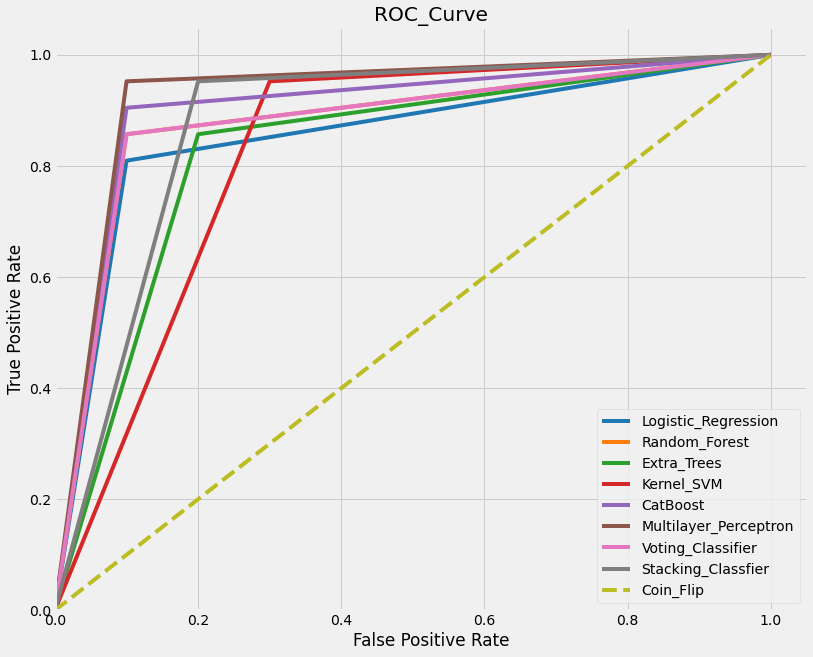

In [89]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='tab:blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='tab:orange', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='tab:green', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='tab:red', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='tab:purple', label='CatBoost')
plt.plot(fpr_MLP, tpr_MLP, linestyle='-', color='tab:brown', label='Multilayer_Perceptron')
plt.plot(fpr_VOC, tpr_VOC, linestyle='-', color='tab:pink', label='Voting_Classifier')
plt.plot(fpr_STC, tpr_STC, linestyle='-', color='tab:grey', label='Stacking_Classfier')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='tab:olive', label="Coin_Flip")
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

#### Precision Recall Curve

Text(0.5, 1.0, 'Precision-Recall curve')

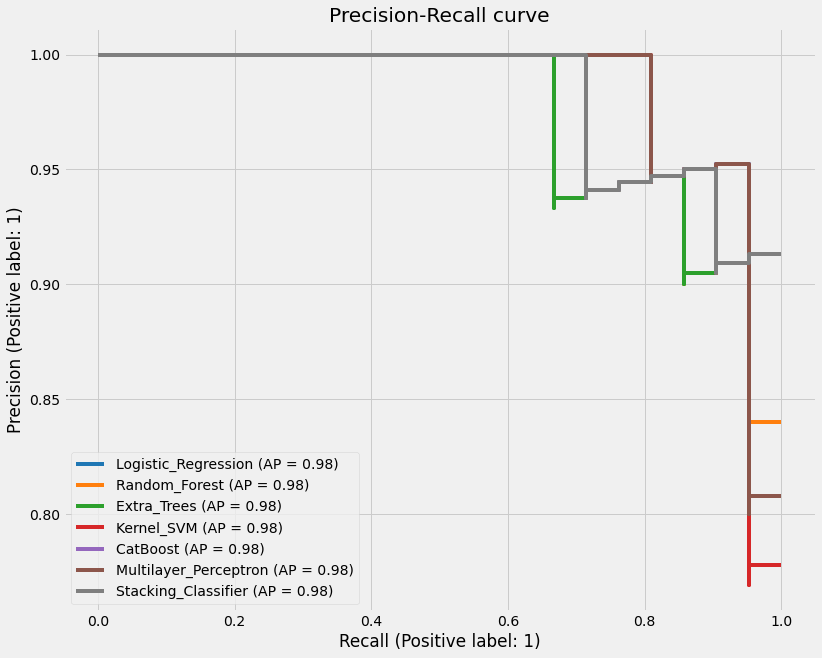

In [90]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Log_Reg, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:blue', name = "Logistic_Regression")
plot_precision_recall_curve(RFC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:orange', name = "Random_Forest")
plot_precision_recall_curve(ETC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:green', name = "Extra_Trees")
plot_precision_recall_curve(KSV, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:red', name = "Kernel_SVM")
plot_precision_recall_curve(CBC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:purple', name = "CatBoost")
plot_precision_recall_curve(MLP, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:brown', name = "Multilayer_Perceptron")
plot_precision_recall_curve(STC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:grey', name = "Stacking_Classifier")
plt.legend(loc='best')
plt.title('Precision-Recall curve')

#### SHAP Model Explainer

In [91]:
# Model Explainability Using SHAP - CatBoost Classifier

explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [92]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


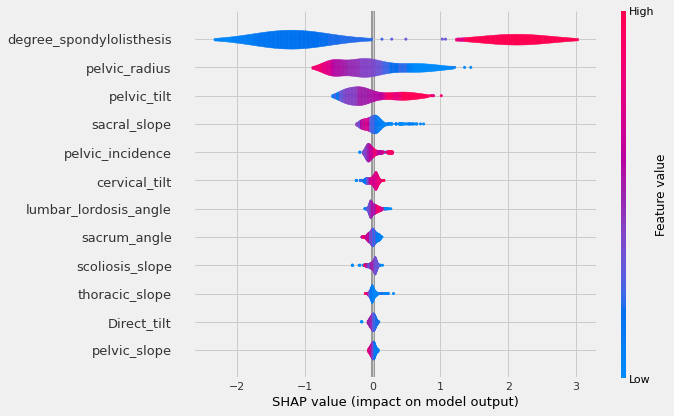

In [93]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst), title='CatBoost Model Explainer')

In [94]:
OUTFILE = r"Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='Metrics', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Report', index=True)
writer.save()

#### Notebook to HTML

In [95]:
# !jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" GS_MLM_CLF_V2.2.ipynb --to html

In [ ]:
NB_Convert = u"jupyter nbconvert --to html_toc --output " # Trailing space is required.
NB_Name = u"GS_MLM_CLF_V2.2_LowerBackPain.ipynb"
PREFIX_A = PREFIX[:-1]
HTML_Name = PREFIX_A.replace("\\", "") + " " # Trailing space is required.
Names_Concat = NB_Convert + HTML_Name + NB_Name
try:
    if(__IPYTHON__):
        get_ipython().system(Names_Concat)
except NameError:
    pass